# Technical Analysis Techniques
write description for bollinger bands 

### Import Packages

In [1]:
# download yfinance API as the way to get historical data
import yfinance as yf

# import numpy for mathemiatcal functions
import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import pandas for dataframe functions
import pandas as pd

### Functions for Downloading Data
- 'get_data_from_start_to_end': Load in the data from YFinance API
- 'download_stock_data_for_periods': Look at different periods to understand how technical analysis changes throughout changes in macroeconomy
- 'get_adjusted_closed_price': Create a dataframe which gets the adjusted close price for period 

In [2]:
missing_data_tickers = []

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
# create adjusted close price only listing of sector etfs
def get_adjusted_closed_price(nested_dict,tickers):
    stock_price_df = pd.DataFrame()

    for ticker in tickers:
        stock_price_df[ticker] = nested_dict[ticker]['Adj Close']
    
    return stock_price_df

### Functions for Paper Trading
'track_investment_history': Will track the times when stocks were bought or sold as well as the value of the investment (one stock only)

In [5]:
def track_investment_history(tickers, periods, initial_investment_df, data_df, 
                             percentage_for_purchase_buy, percentage_for_purchase_sell):
    """
    Tracks investment history for given tickers and periods based on provided data and initial investments.

    Parameters:
    - tickers: List of tickers to track.
    - periods: List of periods to consider.
    - initial_investment_df: DataFrame containing initial investments for each ticker and period.
    - data_df: Nested dictionary-like structure containing data with 'Adj Close' and 'Signal' columns.
               Example format: {period: {ticker: pd.DataFrame()}}
    - percentage_for_purchase_buy: Percentage of current balance to invest when buying (default is 0.05).
    - percentage_for_purchase_sell: Percentage of current shares to sell (default is 0.03).

    Returns:
    - investment_history: Dictionary with investment history for each ticker and period.
    """
    # Initialize a dictionary to track investment history
    investment_history = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods}

    # Iterate over each ticker and period
    for ticker in tickers:
        for period in periods:
            # Check if data for the ticker and period is available
            if ticker not in data_df.get(period, {}):
                print(f"Data for {ticker} in period {period} is missing. Skipping...")
                continue

            # Set the initial investment for each stock
            initial_investment = initial_investment_df.loc[ticker, period]

            # Initialize current balance and investment tracking
            portfolio_balance = initial_investment
            shares_value = 0
            shares_number = 0
            investment_value = initial_investment
            profit = 0

            # Extract relevant data
            data = data_df[period][ticker][['Adj Close', 'Signal']].copy()

            # Track investments
            investment_tracker = []

            # Iterate through each row in the data
            for index, row in data.iterrows():
                if row['Signal'] == 'Buy':
                    amount_to_buy = percentage_for_purchase_buy * portfolio_balance
                    # Check if there is enough balance to buy
                    if portfolio_balance >= amount_to_buy:
                        shares_to_buy = amount_to_buy / row['Adj Close']
                        shares_number += shares_to_buy
                        shares_value = shares_number * row['Adj Close']
                        portfolio_balance -= amount_to_buy
                        investment_value = shares_value + portfolio_balance
                        profit = investment_value - initial_investment

                        investment_tracker.append({
                            'Date': index,
                            'Share Price': row['Adj Close'],
                            'Signal': 'Buy',
                            'Buy/Sell Amount ($)': amount_to_buy,
                            'Buy/Sell Number of Shares': shares_to_buy,
                            'Shares ($) Ownership': shares_value,
                            'Shares Ownership': shares_number,
                            'Account Balance': portfolio_balance,
                            'Investment Value': investment_value,
                            'Profit': profit
                        })

                elif row['Signal'] == 'Sell':
                    amount_to_sell = percentage_for_purchase_sell * shares_value
                    # Check if there are enough shares to sell
                    if shares_value >= amount_to_sell:
                        shares_to_sell = amount_to_sell / row['Adj Close']
                        shares_number -= shares_to_sell
                        shares_value = shares_number * row['Adj Close']
                        portfolio_balance += amount_to_sell
                        investment_value = shares_value + portfolio_balance
                        profit = investment_value - initial_investment

                        investment_tracker.append({
                            'Date': index,
                            'Share Price': row['Adj Close'],
                            'Signal': 'Sell',
                            'Buy/Sell Amount ($)': amount_to_sell,
                            'Buy/Sell Number of Shares': shares_to_sell,
                            'Shares ($) Ownership': shares_value,
                            'Shares Ownership': shares_number,
                            'Account Balance': portfolio_balance,
                            'Investment Value': investment_value,
                            'Profit': profit
                        })
                else:
                    investment_value = (shares_number * row['Adj Close']) + portfolio_balance
                    shares_value = shares_number * row['Adj Close']
                    profit = investment_value - initial_investment

                    investment_tracker.append({
                        'Date': index,
                        'Share Price': row['Adj Close'],
                        'Signal': np.nan,
                        'Buy/Sell Amount ($)': 0,
                        'Buy/Sell Number of Shares': 0,
                        'Shares ($) Ownership': shares_value, 
                        'Shares Ownership': shares_number, 
                        'Account Balance': portfolio_balance, 
                        'Investment Value': investment_value,
                        'Profit': profit
                    })

            # Store the investment history in the dictionary
            investment_history[period][ticker] = pd.DataFrame(investment_tracker)
    
    return investment_history

In [20]:
def return_on_investment(investment_tracker, periods, tickers, column):
    roi = pd.DataFrame(index=tickers, columns=periods)
    for ticker in tickers:
        for period in periods:
            data = investment_tracker[period][ticker]
            if column in data.columns:
                start_price = data[column].iloc[0]
                end_price = data[column].iloc[-1]
                roi.at[ticker, period] = ((end_price - start_price) / start_price) * 100
            else:
                roi.at[ticker, period] = np.nan
    return roi

### Download Data

In [6]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [7]:
# create time periods for where this takes place
economic_cycle_periods = {
    'all_data':('2000-01-01','2024-08-01'),
    "trough": ("2008-01-01", "2009-07-01"),
    "contraction": ("2020-02-01", "2020-04-01"),
    "expansion": ("2016-01-01", "2020-01-01"),
    "recovery": ("2020-10-01", "2024-09-02")
}

economic_cycle_periods_list = ['all_data','trough','contraction','expansion','recovery']

In [8]:
# save data for sector etfs from 2000 to 2024-08-01
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [50]:
sector_etf_adjusted_close = get_adjusted_closed_price(sector_etf_data['all_data'],sector_etf_tickers)
sector_etf_adjusted_close

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2000-01-03,14.953679,18.527153,11.392445,41.704247,22.629522,12.702892,14.077822,21.058607,NaN,11.592999,NaN
2000-01-04,14.809721,18.015303,10.894417,39.588470,21.948761,12.345187,13.812840,20.580732,NaN,11.243295,NaN
2000-01-05,15.421543,17.935003,10.808813,39.000751,21.678793,12.563292,14.177201,20.396109,NaN,11.527018,NaN
2000-01-06,15.817421,18.175886,11.283504,37.707790,21.925283,12.798865,14.723749,20.461271,NaN,11.507223,NaN
2000-01-07,15.808432,18.868389,11.470261,38.366020,22.958157,13.610242,14.881088,20.711067,NaN,11.606198,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,89.860001,124.180000,42.740002,213.570007,180.589996,77.699997,91.900002,149.119995,131.860001,70.480003,91.889999
2024-07-26,91.330002,126.300003,43.410000,216.279999,182.610001,78.489998,92.190002,149.960007,133.779999,71.169998,93.440002
2024-07-29,91.489998,126.080002,43.349998,215.320007,185.660004,78.519997,91.400002,150.050003,134.899994,71.489998,94.040001


## Bollinger Bands

### Functions for Bollinger Bands
'add_bollinger_data': Creates bollinger data (upper, lower and moving average band) as well as signals
'bollinger_data_multiple_periods_tickers': Add bollinger bands in different periods and tickers
'plot_with_boll_bands': Plot data with bollinger bands and buy/sell signal

In [10]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [11]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')

In [79]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data,investment_tracking_df):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(14,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Base Model Bollinger Bands
Using John Bollinger's parameters of a 20 day moving average with 2 standard deviations above and below the moving average line to create channels for the price to move within. If the price goes below 

In [33]:
for ticker in sector_etf_tickers:
    bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [34]:
bollinger_investment = 10000

percentage_to_buy =0.05

percentage_to_sell = 0.05

investment_tracking = pd.DataFrame(bollinger_investment,index=sector_etf_tickers,columns=economic_cycle_periods_list)

bollinger_portfolio_investment = track_investment_history(
    sector_etf_tickers,
    economic_cycle_periods_list,
    investment_tracking,
    sector_etf_data,
    percentage_to_buy,
    percentage_to_sell
)

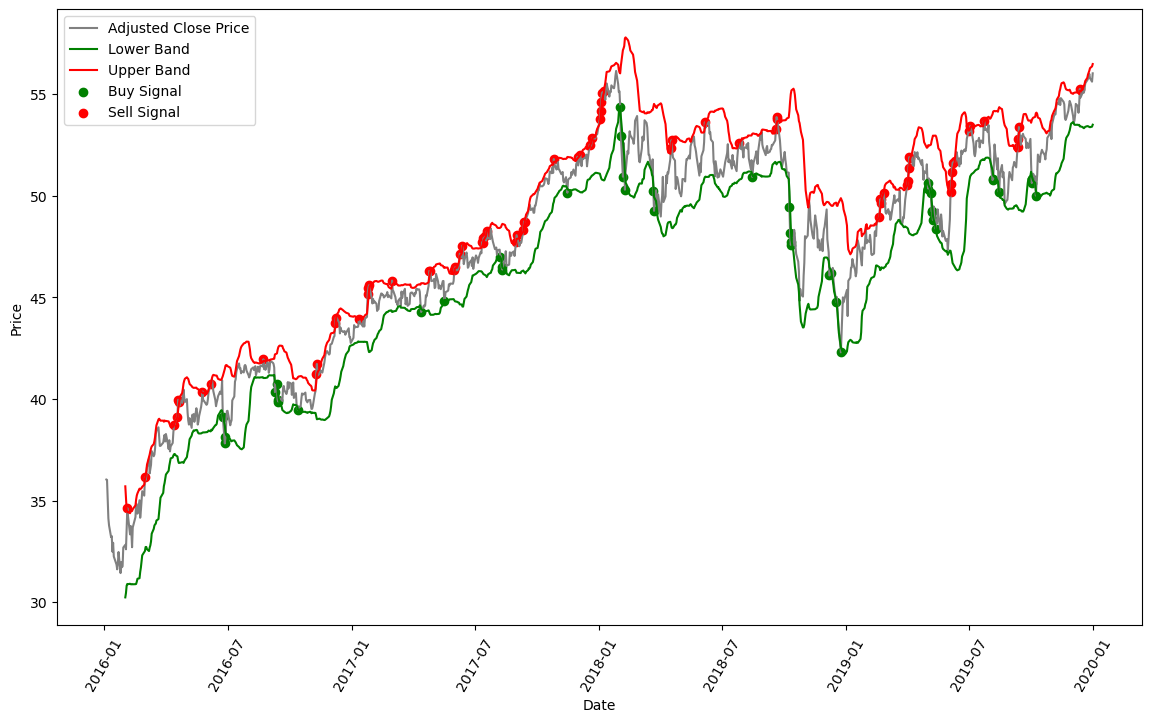

In [80]:
# show an example
plot_with_boll_bands(sector_etf_data['expansion']['XLB'],bollinger_portfolio_investment['expansion']['XLB'])

In [47]:
bollinger_portfolio_investment['expansion']['XLB']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership,Account Balance,Investment Value,Profit
0,2016-01-04,36.036114,NaN,0.0,0.0,0.000000,0.000000,10000.000000,10000.000000,0.000000
1,2016-01-05,36.019249,NaN,0.0,0.0,0.000000,0.000000,10000.000000,10000.000000,0.000000
2,2016-01-06,35.074913,NaN,0.0,0.0,0.000000,0.000000,10000.000000,10000.000000,0.000000
3,2016-01-07,34.122177,NaN,0.0,0.0,0.000000,0.000000,10000.000000,10000.000000,0.000000
4,2016-01-08,33.776482,NaN,0.0,0.0,0.000000,0.000000,10000.000000,10000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1001,2019-12-24,55.754551,NaN,0.0,0.0,5532.895897,99.236669,6245.226654,11778.122551,1778.122551
1002,2019-12-26,56.000851,NaN,0.0,0.0,5557.337863,99.236669,6245.226654,11802.564517,1802.564517
1003,2019-12-27,55.791050,NaN,0.0,0.0,5536.517938,99.236669,6245.226654,11781.744592,1781.744592
1004,2019-12-30,55.617722,NaN,0.0,0.0,5519.317405,99.236669,6245.226654,11764.544059,1764.544059


In [48]:
# display a dataframe which has the return on investment during different time periods
return_on_investment(bollinger_portfolio_investment,economic_cycle_periods_list,sector_etf_tickers,'Investment Value')

,all_data,trough,contraction,expansion,recovery
XLB,281.156639,-16.192525,0.308722,18.052795,19.708176
XLI,226.689151,-14.45861,-0.093904,21.44803,26.766973
XLF,122.572314,-19.269728,-0.251412,26.577889,25.469356
XLK,244.812945,-4.401031,0.771322,43.301536,33.248865
XLY,334.327654,-4.983606,0.161726,33.678694,14.474653
XLP,197.614541,-0.999066,1.338582,16.107805,19.613112
XLE,233.606623,-10.764966,-1.89913,6.413991,52.013636
XLV,247.079529,-3.140581,1.517395,26.371748,25.217246
VOX,148.823599,3.085079,0.213883,10.18638,7.983697
XLU,140.052067,-8.026887,1.818534,21.252917,20.943516


In [55]:
sector_etf_adjusted_close = get_adjusted_closed_price(sector_etf_data['all_data'],sector_etf_tickers)
sector_etf_adjusted_close

<function __main__.get_adjusted_closed_price(nested_dict, tickers)>

In [170]:
import pandas as pd

def get_adjusted_closed_price(nested_dict, tickers, periods):
    all_data = {}
    
    # Create dictionaries to hold DataFrames for all periods
    all_adjusted_close = {}
    all_bollinger_signals = {}

    for period, (start_date, end_date) in periods.items():
        adjusted_close_data = {}
        bollinger_signal_data = {}
        
        # Collect the adjusted close prices and Bollinger signals for each ticker
        for ticker in tickers:
            if ticker in nested_dict.get(period, {}):
                adjusted_close_data[ticker] = nested_dict[period][ticker]['Adj Close']
                bollinger_signal_data[ticker] = nested_dict[period][ticker]['Signal']
        
        # Convert the data into DataFrames
        adjusted_close_df = pd.DataFrame(adjusted_close_data)
        bollinger_signal_df = pd.DataFrame(bollinger_signal_data)
        
        # Store the DataFrames in the dictionary for each period
        all_adjusted_close[period] = adjusted_close_df
        all_bollinger_signals[period] = bollinger_signal_df
        
        # Also store the adjusted close prices and signals as a nested dictionary
        all_data[period] = {
            'Adjusted Close': adjusted_close_df,
            'Bollinger Signal': bollinger_signal_df 
        }
    
    # Return both the nested dictionary and DataFrames
    return all_data

In [ ]:
# create dataframe which tracks the stocks bought and sold and how much money there
portfolio_investment = {}
for period, (start_date, end_date) in economic_cycle_periods.items():
    for ticker in sector_etf_tickers:
        

In [220]:
portfolio_data = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods)

for period in economic_cycle_periods_list:
    for index,row in portfolio_data[period]['Bollinger Signal'].iterrows():
        for idx,value in enumerate(row):
            if value=='Buy':
                print('Buy')
                print(sector_etf_tickers[idx])
                print(portfolio_data[period]['Adjusted Close'].loc[index,sector_etf_tickers[idx]])
            elif value=='Sell':
                print('Sell')
                print(sector_etf_tickers[idx])
                print(portfolio_data[period]['Adjusted Close'].loc[index,sector_etf_tickers[idx]])
            else:
                None

Buy
XLE
13.945334434509277
Buy
XLE
13.514721870422363
Buy
XLF
10.684309005737305
Buy
XLI
16.35930061340332
Buy
XLP
12.04854679107666
Buy
XLY
19.624780654907227
Buy
XLV
20.168041229248047
Buy
XLY
19.06137466430664
Buy
XLV
20.157180786132812
Buy
XLF
10.085112571716309
Buy
XLY
18.779691696166992
Buy
XLP
11.882791519165039
Buy
XLV
19.603290557861328
Buy
XLU
10.550487518310547
Buy
XLY
18.826641082763672
Buy
XLV
19.462100982666016
Buy
XLU
10.51090145111084
Buy
XLU
10.293163299560547
Buy
XLY
18.169340133666992
Buy
XLP
11.568708419799805
Buy
XLU
9.950054168701172
Buy
XLB
12.128494262695312
Buy
XLP
11.280795097351074
Buy
XLE
13.150344848632812
Buy
XLU
9.897272109985352
Sell
XLK
42.87967300415039
Sell
XLK
44.066864013671875
Sell
XLK
43.99633026123047
Buy
XLB
11.408697128295898
Buy
XLP
10.451971054077148
Sell
XLE
15.137799263000488
Sell
XLK
44.85439682006836
Sell
XLF
10.660964012145996
Sell
XLY
19.765621185302734
Sell
XLB
13.136199951171875
Sell
XLI
17.784460067749023
Sell
XLF
11.579207420349121


In [ ]:
# now create a nested dictionary for the portfolios during different periods 

In [179]:
portfolio_data

{'all_data': {'Adjusted Close':                   XLB         XLI        XLF         XLK         XLY  \
  Date                                                                   
  2000-01-03  14.953679   18.527153  11.392445   41.704247   22.629522   
  2000-01-04  14.809721   18.015303  10.894417   39.588470   21.948761   
  2000-01-05  15.421543   17.935003  10.808813   39.000751   21.678793   
  2000-01-06  15.817421   18.175886  11.283504   37.707790   21.925283   
  2000-01-07  15.808432   18.868389  11.470261   38.366020   22.958157   
  ...               ...         ...        ...         ...         ...   
  2024-07-25  89.860001  124.180000  42.740002  213.570007  180.589996   
  2024-07-26  91.330002  126.300003  43.410000  216.279999  182.610001   
  2024-07-29  91.489998  126.080002  43.349998  215.320007  185.660004   
  2024-07-30  91.190002  126.449997  43.849998  209.910004  184.630005   
  2024-07-31  92.139999  127.860001  43.740002  218.800003  187.490005   
  
     

## Base Model